In [1]:
#Este analisis verifica si la cercanía a hospitales y centros de salud privados afecta el precio.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Datos de Properati
#data = pd.read_csv('/home/martin/Documents/jupyter/datasets/properati-AR-2017-08-01-properties-sell.csv')

#Datos procesados
data = pd.read_csv('datos_procesados.csv',low_memory = False)

#Tomo los datos que me interesan: estado, superficie, precio por m2, latitud y longitud)
data2 = data[['state_name','price_usd_per_m2','lat', 'lon']]

#Elimino NAs
data2.dropna(inplace=True)

#Separo los datos en Capital Federal
dataCF = data2[data2['state_name']== 'Capital Federal']

/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [3]:
#Datos de establecimientos de salud

#Hospitales. Datos extraídos de: https://data.buenosaires.gob.ar/dataset/areas-hospitalarias
hospital = pd.read_csv('areas-hospitalarias.csv', sep = ";",low_memory = False) 

#Centros de salud privados. Datos extraídos de: https://data.buenosaires.gob.ar/dataset/centros-de-salud-privados
privado = pd.read_csv('centros-de-salud-privados.csv', sep = ";",low_memory = False) 

In [4]:
privado.sample(5)


,NOMBRE,DIRECCION,CALLE,ALTURA,PISO,TELEFONOS,OBSERV,BARRIO,COMUNA,CODIGO_POSTAL,CODIGO_POSTAL_ARGENTINO,LAT,LNG
54,CLINICA PSIQUIATRICA VILLA GUADALUPE,"SCALABRINI ORTIZ, RAUL AV. 1963","SCALABRINI ORTIZ, RAUL AV.",1963,NaN,NaN,NOVIEMBRE 2012:SIN PAGINA EN INTERNET PARA CHE...,PALERMO,COMUNA 14,1425,C1425DBA,"-34,58900803","-58,4216593"
33,SANATORIO AGOTE,"AGOTE, LUIS DR. 2479","AGOTE, LUIS DR.",2479,NaN,5239-6700,NOVIEMBRE 2012:OK,RECOLETA,COMUNA 2,1425,C1425EOE,"-34,58539991","-58,39452861"
25,HOSPITAL MILITAR CENTRAL,"CAMPOS, LUIS M. AV. 726","CAMPOS, LUIS M. AV.",726,NaN,4576-5737 / 5659,NOVIEMBRE 2012:OK,PALERMO,COMUNA 14,1426,C1426BOS,"-34,57014122","-58,43616155"
10,CLINICA MILITO,CALLAO AV. 1121,CALLAO AV.,1121,PISO 1,4814-0050,NOVIEMBRE 2012:OK,RECOLETA,COMUNA 2,1023,C1023AAE,"-34,59566122","-58,39301567"
59,CRUZ AZUL ASISTENCIA MEDICA,"QUINTANA, MANUEL, PRES. 281","QUINTANA, MANUEL, PRES.",281,NaN,NaN,NOVIEMBRE 2012:SIN PAGINA EN INTERNET PARA CHE...,RECOLETA,COMUNA 2,1014,C1014ACC,"-34,59006655","-58,38756525"


In [5]:
#Tomo los datos que me interesan
privado2 = privado[['NOMBRE','LAT','LNG']]
#Cambio las comas en latitud y longitud por puntos para poder usarlos como float
privado2['lat'] = privado2['LAT'].str.replace(',','.').astype(float)
privado2['lon'] = privado2['LNG'].str.replace(',','.').astype(float)

privado = privado2[['NOMBRE','lat','lon']]
privado.sample(5)

/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,NOMBRE,lat,lon
52,CLINICA Y MATERNIDAD SUIZO ARGENTINA,-34.593846,-58.401788
8,CLINICA JURI,-34.581162,-58.405666
43,SANATORIO SAN PATRICIO,-34.629510,-58.466835
40,SANATORIO MITRE,-34.608437,-58.402713
14,EXCELSITAS,-34.569124,-58.449685


In [6]:
hospital2 = hospital[['NOMBRE','WKT']]
hospital2.sample(5)
#Esto queda para hacer después (no sé geopandas)

,NOMBRE,WKT
11,HTAL. DR. C. ARGERICH,POLYGON ((-58.373264347334342 -34.655931622539...
5,HTAL. DR. F. SANTOJANI,POLYGON ((-58.474548852531036 -34.674558997865...
6,"HTAL. DR, E. TORNU",POLYGON ((-58.467044778470367 -34.579089660706...
2,HTAL. DR. C.G. DURAND,POLYGON ((-58.426948408976038 -34.596211287114...
10,HTAL. J.M. PENNA,POLYGON ((-58.382809436984942 -34.627861801861...


In [7]:
#Busco, para cada propiedad, el centro de salud más cercano

#Agrego una columna donde irá la distancia minima al centro de salud más cercano
precio_segun_distancia = dataCF.copy()
#Agrego 2 columnas donde va a ir la informacion
precio_segun_distancia['distancia_minima_hospital (m)'] = 0
precio_segun_distancia.head(10)
privado.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 3 columns):
NOMBRE    65 non-null object
lat       65 non-null float64
lon       65 non-null float64
dtypes: float64(2), object(1)
memory usage: 1.6+ KB


In [8]:
#Defino una funcion que calcula la distancia entre dos puntos
import math
def dist(lat1,lon1,lat2,lon2):
    dLat = math.radians(lat2-lat1)
    dLon = math.radians(lon2-lon1)

    lat1 = math.radians(lat1)
    lat2 = math.radians(lat2)

    a = math.sin(dLat/2) * math.sin(dLat/2) + math.sin(dLon/2) * math.sin(dLon/2) * math.cos(lat1) * math.cos(lat2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    return c * 6371 * 1000
    #return np.abs((lat1 - lat2) + (lon1 - lon2))

def encontrar_escuela_mas_cercana(lat, lon):
    distancias = privado.apply(lambda row: dist(lat, lon, row['lat'], row['lon']), axis=1)
    return privado.loc[distancias.idxmin(), 'NOMBRE']

def dist2(lat,lon):
    distancias = privado.apply(lambda row: dist(lat, lon, row['lat'], row['lon']), axis=1)
    return distancias.min()
    
precio_segun_distancia['hospital_mas_cercano'] = precio_segun_distancia.apply(lambda row: encontrar_escuela_mas_cercana(row['lat'], row['lon']), axis=1)
precio_segun_distancia['distancia_minima_hospital (m)'] = precio_segun_distancia.apply(lambda row: dist2(row['lat'],row['lon']), axis=1)
precio_segun_distancia.head(10)


,state_name,price_usd_per_m2,lat,lon,distancia_minima_hospital (m),hospital_mas_cercano
360720,Capital Federal,2448.275862,-34.574594,-58.419255,442.208980,SANATORIO DE LA TRINIDAD
360734,Capital Federal,2042.553191,-34.610611,-58.479590,1108.239918,HOSPITAL ISRAELITA- ISRAMED
360735,Capital Federal,1829.787234,-34.610611,-58.479590,1108.239918,HOSPITAL ISRAELITA- ISRAMED
360742,Capital Federal,1918.604651,-34.639086,-58.369347,1769.477226,HOSPITAL BRITANICO DE BUENOS AIRES
360759,Capital Federal,1307.692308,-34.678121,-58.392211,3343.996462,HOSPITAL AERONAUTICO CENTRAL
360766,Capital Federal,1625.714286,-34.611630,-58.401346,342.759688,CLINICA CIUDAD DE LA VIDA
360768,Capital Federal,2745.098039,-34.569881,-58.441754,512.898739,HOSPITAL MILITAR CENTRAL
360785,Capital Federal,2279.225000,-34.593436,-58.442285,1425.154531,CLINICA SAN CAMILO
360786,Capital Federal,2256.675000,-34.593422,-58.442303,1426.677071,CLINICA SAN CAMILO
360787,Capital Federal,2234.325000,-34.593422,-58.442303,1426.677071,CLINICA SAN CAMILO


In [9]:
print(len(precio_segun_distancia))
precio_segun_distancia.dropna(inplace=True)
print(len(precio_segun_distancia))

36942
36942


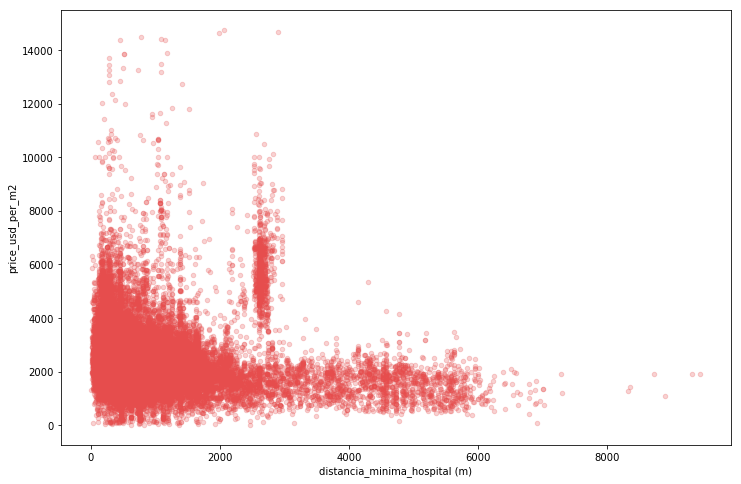

In [12]:
%matplotlib inline
precio_segun_distancia = precio_segun_distancia[precio_segun_distancia['price_usd_per_m2']< 15000]
precio_segun_distancia = precio_segun_distancia[precio_segun_distancia['distancia_minima_hospital (m)']< 10000]
precio_segun_distancia.plot.scatter('distancia_minima_hospital (m)', 'price_usd_per_m2',alpha=0.25, figsize=(12,8),color=(0.9,0.3,0.3))